# Build a TextCNN  model



### Building and training the model


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,roc_curve, roc_auc_score
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping

In [2]:
#POS_RATING_THRESHOLD = 5
POS_RATING_THRESHOLD = 3

In [3]:
# Import the dataset. 
train_dataset = pd.read_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= POS_RATING_THRESHOLD
train_dataset = train_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                               'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [4]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
1,okay anxiety gotten worse past couple years po...,0.12980,0.4067,150.0,0.06000,0.00000,0.0,0.0,0.0,0.0,0.0,True
6,reading possible effects scary medicine gave l...,0.07983,0.5347,90.0,0.07776,0.01111,0.0,0.0,0.0,0.0,0.0,True
9,clonazepam effective controlling agitation pro...,0.23700,0.6855,118.0,0.03390,0.00848,0.0,0.0,0.0,0.0,0.0,True
11,experienced effects considering anorexia nervo...,0.50630,0.5750,47.0,0.10640,0.02127,0.0,0.0,0.0,0.0,0.0,True
12,i&#039;ve gianvi months skin clear didn&#039;t...,-0.10710,0.3894,54.0,0.05554,0.01852,0.0,0.0,0.0,0.0,0.0,True


In [5]:
from sklearn.preprocessing import  MinMaxScaler
# Instantiate the MinMaxScaler
train_scaler = MinMaxScaler()
# Scale the features
train_dataset.iloc[:, 1:11] = train_scaler.fit_transform(train_dataset.iloc[:, 1:11])
train_dataset.iloc[:, 1:11].head()

,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ
1,0.564900,0.4067,0.263717,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.539915,0.5347,0.157522,0.081000,0.037033,0.0,0.0,0.0,0.0,0.0
9,0.618500,0.6855,0.207080,0.035313,0.028267,0.0,0.0,0.0,0.0,0.0
11,0.753150,0.5750,0.081416,0.110833,0.070900,0.0,0.0,0.0,0.0,0.0
12,0.446450,0.3894,0.093805,0.057854,0.061733,0.0,0.0,0.0,0.0,0.0


In [6]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('drugreview/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= POS_RATING_THRESHOLD
val_dataset = val_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                           'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [7]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
1,4yrs having nexaplon implant mental physical h...,0.1217,0.4553,137.0,0.02919,0.007298,0.0,0.0,0.0,0.0,0.0,False
4,l5 s1 lumbar herniated disc surgery weeks surg...,0.1459,0.3792,69.0,0.04350,0.028990,0.0,0.0,0.0,0.0,0.0,True
5,far lot acne clear tea tree broke decided birt...,0.2375,0.5540,85.0,0.11770,0.011765,0.0,0.0,0.0,0.0,0.0,True
6,insulin works fine trouble pen pain pen jammed...,-0.0958,0.5500,47.0,0.08510,0.000000,0.0,0.0,0.0,0.0,0.0,True
7,nexplanon option work iud painful insert pills...,-0.0353,0.4426,135.0,0.05927,0.007410,0.0,0.0,0.0,0.0,0.0,True


In [8]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate the StandardScaler
val_scaler = MinMaxScaler()
# Scale the features
val_dataset.iloc[:, 1:11] = val_scaler.fit_transform(val_dataset.iloc[:, 1:11])
val_dataset.iloc[:, 1:11].head()

,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ
1,0.56085,0.4553,0.123412,0.030954,0.026271,0.0,0.0,0.0,0.0,0.0
4,0.57295,0.3792,0.061706,0.046129,0.104356,0.0,0.0,0.0,0.0,0.0
5,0.61875,0.5540,0.076225,0.124814,0.042351,0.0,0.0,0.0,0.0,0.0
6,0.45210,0.5500,0.041742,0.090244,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.48235,0.4426,0.121597,0.062853,0.026674,0.0,0.0,0.0,0.0,0.0


In [9]:


train_iterator = BatchIterator(train_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.7,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
14773/39267 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 48
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12312/14777 of pre-trained word vectors.
2465 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [10]:
val_iterator = BatchIterator(val_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.7, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_val.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
7720/19770 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 47
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [11]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_feat', 'input_seq', 'target', 'x_lengths'])


Notice that the output batch has the dimensions: (batch_size, seq_len)

In [12]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([256, 37])
target shape:  torch.Size([256])
x_lengths shape:  torch.Size([256])


In [13]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([256, 48])
target shape:  torch.Size([256])
x_lengths shape:  torch.Size([256])


Next step is to build the TextCNN model.

In [14]:
class TextCNN(nn.Module):

    
    def __init__(self, conv_config, weights_matrix, output_size, dropout=0.2):
        
        # Inherit everything from the nn.Module
        super(TextCNN, self).__init__()
        
        # Initialize attributes
        self.conv_config = conv_config
        self.output_size = output_size
        self.weights_matrix = weights_matrix
        self.dropout_p = dropout
        self.vocab_size, self.embedding_dim = self.weights_matrix.shape
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # Load the weights to the embedding layer
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        self.embedding.weight.requires_grad = False          
            
        self.convolutions = nn.ModuleList([nn.Sequential(
            nn.Conv1d(self.embedding_dim, self.conv_config['num_channels'], kernel_size=kernel),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d((1,)))\
                         for kernel in self.conv_config['kernel_sizes']])    
            
        self.dropout = nn.Dropout(self.dropout_p)    
        self.linear = nn.Linear(self.conv_config['num_channels'] * len(self.conv_config['kernel_sizes']),\
                                                                       self.output_size)

        
    def forward(self, input_seq):
        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, embedding_dim, seq_length)
        emb_out = self.embedding(input_seq).permute(0,2,1)

        # Conv1d -> Relu -> AdaptiveMaxPool1d
        # Input: (batch_size, embedding_dim, seq_length)
        # Output: (batch_size, num_channels)
            
        conv_out = [conv(emb_out).squeeze(2) for conv in self.convolutions]       

        # Concatenate the list of convolving outputs from the previous step
        concat_out = torch.cat(conv_out, dim=1)

        concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):

        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):

        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
    
        self.device = device
    
    
    def train_model(self, train_iterator):
       
        self.train()
        
        losses_list = []
        num_seq = 0
        batch_correct = 0
        train_losses = []
        losses = []
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
       
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        all_y_hat = torch.FloatTensor()
        all_y_true = torch.LongTensor()
        all_y_pred = torch.LongTensor()
 
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                #y_hat = pred.view(pred.shape[1])
                #y_pred = y_hat.clone()
                #y_pred = torch.tensor([1 if p > 0.5 else 0 for p in y_hat])
                y_pred = np.exp(pred[:,1])
                y_pred  = np.multiply((y_pred>0.5),1.0)
                all_y_pred =  torch.cat((all_y_pred, y_pred.to('cpu').long()),dim=0)
                all_y_hat =  torch.cat((all_y_hat, pred.to('cpu').float()),dim=0)
                
                
                pred = torch.argmax(pred, 1)
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)

                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
   
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
            
            roc = roc_auc_score(target_total.view(-1),all_y_hat[:,1])
            fone_score = f1_score(target_total.view(-1),pred_total.view(-1))
            fpr, tpr, threshold1 = roc_curve(target_total.view(-1), all_y_hat[:,1])

        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix,fone_score,fpr,tpr,roc


In [15]:

# Initialize parameters
conv_config = {'num_channels': 50, 'kernel_sizes': [1,2]}
output_size = 2
learning_rate = 0.001
epochs = 50
dropout = 0.2

# Load the weights matrix
weights = np.load('glove/weights_train.npy')

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = TextCNN(conv_config, weights, output_size, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list,f1_score_list,roc_list = [], [], [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix,fone_score,fpr,tpr,roc = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    f1_score_list.append(fone_score)
    roc_list.append(roc)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4648. Accuracy: 0.817


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [1/50]: Train accuracy: 0.821. Train loss: 0.4453. Evaluation accuracy: 0.825. Evaluation loss: 0.4018

Start epoch [2/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3926. Accuracy: 0.832


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [2/50]: Train accuracy: 0.834. Train loss: 0.3880. Evaluation accuracy: 0.839. Evaluation loss: 0.3700

Start epoch [3/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3695. Accuracy: 0.841


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [3/50]: Train accuracy: 0.843. Train loss: 0.3674. Evaluation accuracy: 0.846. Evaluation loss: 0.3566

Start epoch [4/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3542. Accuracy: 0.846


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [4/50]: Train accuracy: 0.848. Train loss: 0.3538. Evaluation accuracy: 0.851. Evaluation loss: 0.3488

Start epoch [5/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3442. Accuracy: 0.851


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [5/50]: Train accuracy: 0.852. Train loss: 0.3434. Evaluation accuracy: 0.851. Evaluation loss: 0.3440

Start epoch [6/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3358. Accuracy: 0.857


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [6/50]: Train accuracy: 0.858. Train loss: 0.3344. Evaluation accuracy: 0.853. Evaluation loss: 0.3413

Start epoch [7/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3281. Accuracy: 0.859


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [7/50]: Train accuracy: 0.861. Train loss: 0.3284. Evaluation accuracy: 0.854. Evaluation loss: 0.3392

Start epoch [8/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3230. Accuracy: 0.863


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [8/50]: Train accuracy: 0.863. Train loss: 0.3233. Evaluation accuracy: 0.853. Evaluation loss: 0.3381

Start epoch [9/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3164. Accuracy: 0.864


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [9/50]: Train accuracy: 0.865. Train loss: 0.3151. Evaluation accuracy: 0.855. Evaluation loss: 0.3363

Start epoch [10/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3090. Accuracy: 0.868


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [10/50]: Train accuracy: 0.868. Train loss: 0.3101. Evaluation accuracy: 0.855. Evaluation loss: 0.3366

Start epoch [11/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3037. Accuracy: 0.869


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [11/50]: Train accuracy: 0.870. Train loss: 0.3046. Evaluation accuracy: 0.856. Evaluation loss: 0.3368

Start epoch [12/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3019. Accuracy: 0.871


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [12/50]: Train accuracy: 0.872. Train loss: 0.3026. Evaluation accuracy: 0.854. Evaluation loss: 0.3354

Start epoch [13/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.2946. Accuracy: 0.874


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [13/50]: Train accuracy: 0.873. Train loss: 0.2980. Evaluation accuracy: 0.855. Evaluation loss: 0.3356

Start epoch [14/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.2930. Accuracy: 0.875


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [14/50]: Train accuracy: 0.875. Train loss: 0.2938. Evaluation accuracy: 0.855. Evaluation loss: 0.3378

Start epoch [15/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.2913. Accuracy: 0.876


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [15/50]: Train accuracy: 0.877. Train loss: 0.2916. Evaluation accuracy: 0.856. Evaluation loss: 0.3382

Start epoch [16/50]


Training:   0%|          | 0/177 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.2851. Accuracy: 0.879


Evaluation:   0%|          | 0/45 [00:00<?, ?it/s]


Epoch [16/50]: Train accuracy: 0.879. Train loss: 0.2864. Evaluation accuracy: 0.857. Evaluation loss: 0.3369

Training stoped by EarlyStopping


In [16]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])
print("f1_score:",np.mean(f1_score_list))
print("roc:",np.mean(roc_list))

f1_score: 0.9146963744721444
roc: 0.8431044078897006


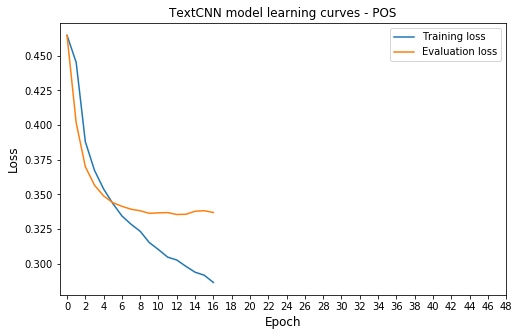

In [26]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('TextCNN model learning curves - POS')
plt.xticks(ticks=range(0,49,2))
plt.legend()
plt.show()

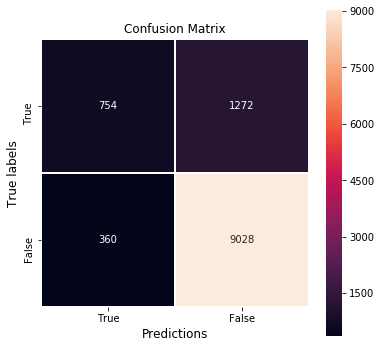

In [18]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [19]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= POS_RATING_THRESHOLD
test_dataset = test_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                           'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [20]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,i&#039;ve tried antidepressants years citalopr...,0.0000,0.4400,68.0,0.02942,0.00000,0.02942,0.1765,0.3381,0.22060,0.04413,True
1,son crohn&#039;s disease asacol complaints sho...,0.5670,0.6000,48.0,0.00000,0.00000,0.04166,0.1875,0.2291,0.14590,0.06250,True
2,quick reduction symptoms,0.3333,0.5000,4.0,0.00000,0.00000,0.00000,0.0000,0.5000,0.50000,0.25000,True
3,contrave combines drugs alcohol smoking opioid...,0.1390,0.5000,143.0,0.06995,0.00000,0.04895,0.2238,0.2098,0.16090,0.06290,True
4,birth control cycle reading reviews type simil...,0.2610,0.5503,149.0,0.06714,0.01342,0.00000,0.1879,0.1879,0.07385,0.08720,True


In [21]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
15210/40911 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 13890/17168 of pre-trained word vectors.
3278 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [22]:
_, test_avg_loss, test_accuracy, test_conf_matrix,test_f1_score,fpr,tpr,roc = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/189 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.3036. Accuracy: 0.87


In [23]:
print('Test accuracy: {:.3f}. Test error: {:.3f}. Test f1_score{:.3f} Test roc{:.3f}'.format(test_accuracy, test_avg_loss,test_f1_score,roc))

Test accuracy: 0.870. Test error: 0.305. Test f1_score0.924 Test roc0.885


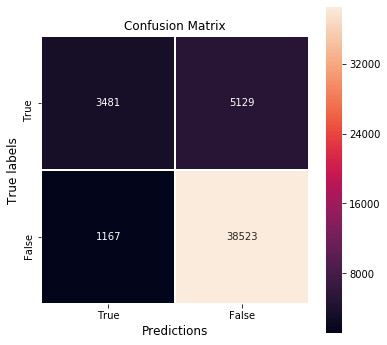

In [24]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The generalization accuracy of the TextCNN model is 0.839. As we can see in the above plot of the confusion matrix the number of False negative predictions (760) is greater than the amount of False positive predictions (7601) which is good.

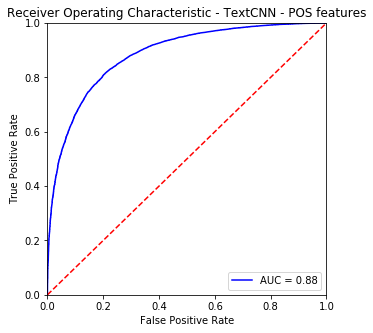

In [27]:
plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - TextCNN - POS features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()